## Analyze IMU Errors on the dataset


In [12]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import json
import matplotlib.pyplot as plt

# Get environment variables
import sys

sys.path.append("..")  # Add the parent directory of notebooks to sys.path

from lac.plotting import pose_traces

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# IMU reverse engineering

Reference: `Leaderboard/leaderboard/agents/imu.py`


In [19]:
from scipy.spatial.transform import Rotation

from lac.util import skew_symmetric, normalize_rotation_matrix

In [22]:
casename = "20hz_seed4"
data_path = "../../output/imu/" + casename + ".json"
json_data = json.load(open(f"{data_path}"))

poses = []
imu_data = []

for frame in json_data["frames"]:
    poses.append(np.array(frame["pose"]))
    imu_data.append(np.array(frame["imu"]))

imu_data = np.array(imu_data)

## Backing out rotations from gyro


In [23]:
R_0 = poses[0][:3, :3]

imu_rotations = []
imu_rotations.append(R_0)

for i in range(1, len(poses)):
    w_hat = skew_symmetric(imu_data[i, 3:])
    dt = json_data["frames"][i]["mission_time"] - json_data["frames"][i - 1]["mission_time"]
    R_1 = (np.eye(3) - w_hat * dt).T @ R_0
    R_1 = normalize_rotation_matrix(R_1)
    imu_rotations.append(R_1)
    R_0 = R_1

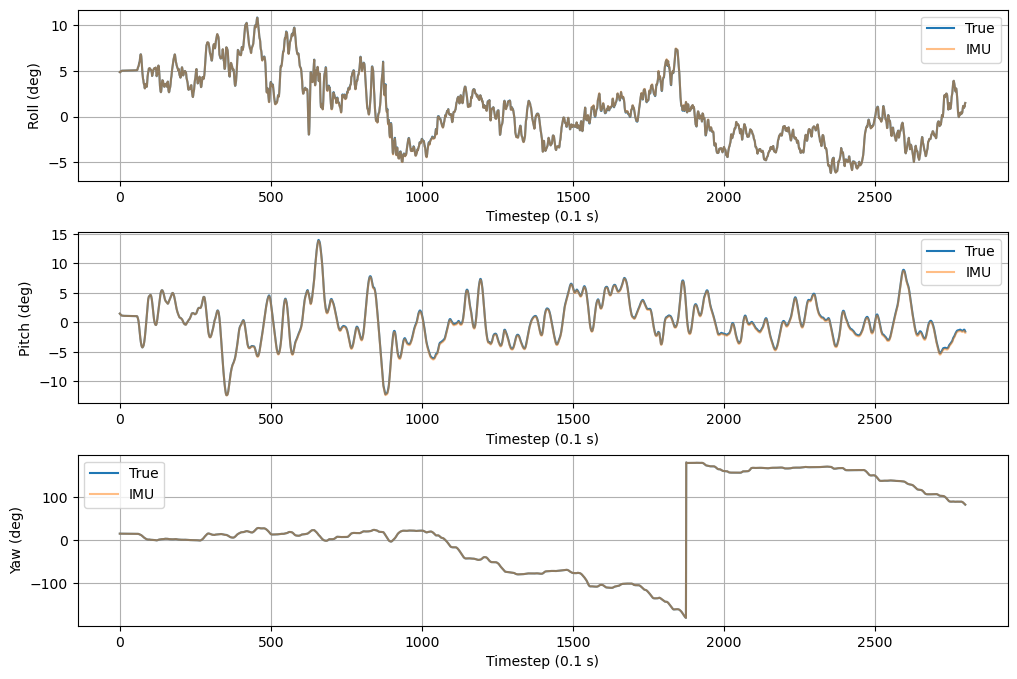

In [24]:
gt_rotations_euler = np.zeros((len(poses), 3))
imu_rotations_euler = np.zeros((len(poses), 3))

for i in range(len(poses)):
    gt_rotations_euler[i] = Rotation.from_matrix(poses[i][:3, :3]).as_euler("xyz", degrees=True)
    imu_rotations_euler[i] = Rotation.from_matrix(imu_rotations[i]).as_euler("xyz", degrees=True)

fig, axes = plt.subplots(3, 1, figsize=(12, 8))
pos_labels = ["Roll (deg)", "Pitch (deg)", "Yaw (deg)"]
for i in range(3):
    ax = axes[i]
    ax.plot(gt_rotations_euler[:, i], label="True")
    ax.plot(imu_rotations_euler[:, i], label="IMU", alpha=0.5)
    ax.legend()
    ax.grid()
    ax.set_xlabel("Timestep (0.1 s)")
    ax.set_ylabel(f"{pos_labels[i]}")
plt.subplots_adjust(wspace=0.0, hspace=0.3)

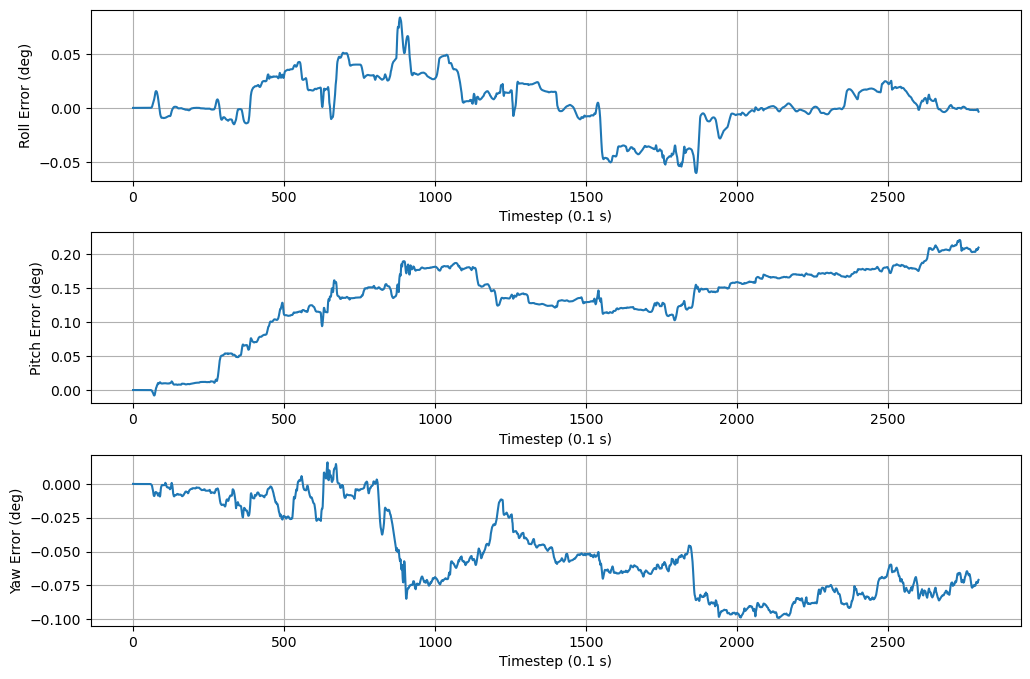

In [25]:
# Error plots
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
pos_labels = ["Roll", "Pitch", "Yaw"]
for i in range(3):
    ax = axes[i]
    ax.plot(gt_rotations_euler[:, i] - imu_rotations_euler[:, i])
    ax.grid()
    ax.set_xlabel("Timestep (0.1 s)")
    ax.set_ylabel(f"{pos_labels[i]} Error (deg)")
plt.subplots_adjust(wspace=0.0, hspace=0.3)

In [26]:
print("Average error in degrees")
print(np.mean(np.abs(gt_rotations_euler - imu_rotations_euler), axis=0))

Average error in degrees
[0.01794753 0.1325308  0.05050215]


## Translations from accelerometer


In [31]:
gravity = np.array([0.0, 0.0, 1.6220])  # m/s^2

use_true_rot = False

t_0 = poses[0][:3, 3]
t_1 = poses[1][:3, 3]
v_1 = (t_1 - t_0) / (json_data["frames"][1]["mission_time"] - json_data["frames"][0]["mission_time"])

imu_translations = []
imu_translations.append(t_0)
imu_translations.append(t_1)

for i in range(2, len(poses)):
    dt = json_data["frames"][i]["mission_time"] - json_data["frames"][i - 1]["mission_time"]
    a = imu_data[i, :3]

    if use_true_rot:
        R_i = poses[i][:3, :3]
    else:
        R_i = imu_rotations[i]

    v_2 = v_1 + (R_i @ a - gravity) * dt
    t_2 = t_1 + v_1 * dt

    imu_translations.append(t_2)
    t_0 = t_1
    t_1 = t_2
    v_1 = v_2

imu_translations = np.array(imu_translations)

gt_translations = np.zeros((len(poses), 3))
for i in range(len(poses)):
    gt_translations[i] = poses[i][:3, 3]

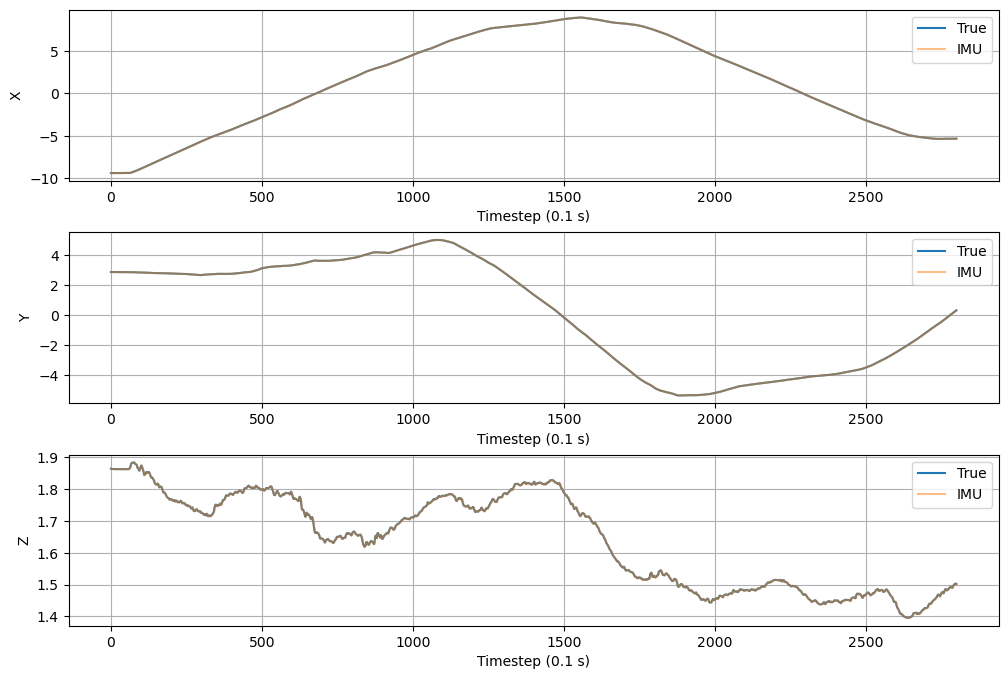

In [32]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
pos_labels = ["X", "Y", "Z"]

N = -1

for i in range(3):
    ax = axes[i]
    ax.plot(gt_translations[:N, i], label="True")
    ax.plot(imu_translations[:N, i], label="IMU", alpha=0.5)
    ax.legend()
    ax.grid()
    ax.set_xlabel("Timestep (0.1 s)")
    ax.set_ylabel(f"{pos_labels[i]}")
plt.subplots_adjust(wspace=0.0, hspace=0.3)

In [ ]:
gt_translations - imu_translations